## This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Import necessary packages.
import numpy as np
import pandas as pd
import pydicom

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms

# learning rate
# from torch_lr_finder import LRFinder

# This is for the progress bar.
from tqdm.auto import tqdm
# This is for ploting
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
# train_df[train_df['study_id'] == 100206310]
train_label =pd.read_csv( "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv")
train_series =pd.read_csv( "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv")
test_desc_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_series_descriptions.csv')

In [3]:
print('TRAIN DATA')
display(train_df.head())

print('TRAIN LABEL and coordinate')
display(train_label.head())

print('TRAIN SERIES')
display(train_series.head() )

TRAIN DATA


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


TRAIN LABEL and coordinate


,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602


TRAIN SERIES


,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1


In [4]:
print('TRAIN DATA')
display(train_df.info())

print('TRAIN LABEL and coordinate')
display(train_label.info())

print('TRAIN SERIES')
display(train_series.info() )

TRAIN DATA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1975 entries, 0 to 1974
Data columns (total 26 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   study_id                                1975 non-null   int64 
 1   spinal_canal_stenosis_l1_l2             1974 non-null   object
 2   spinal_canal_stenosis_l2_l3             1974 non-null   object
 3   spinal_canal_stenosis_l3_l4             1974 non-null   object
 4   spinal_canal_stenosis_l4_l5             1974 non-null   object
 5   spinal_canal_stenosis_l5_s1             1974 non-null   object
 6   left_neural_foraminal_narrowing_l1_l2   1973 non-null   object
 7   left_neural_foraminal_narrowing_l2_l3   1973 non-null   object
 8   left_neural_foraminal_narrowing_l3_l4   1973 non-null   object
 9   left_neural_foraminal_narrowing_l4_l5   1973 non-null   object
 10  left_neural_foraminal_narrowing_l5_s1   1973 non-null   objec

None

TRAIN LABEL and coordinate
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48692 entries, 0 to 48691
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   study_id         48692 non-null  int64  
 1   series_id        48692 non-null  int64  
 2   instance_number  48692 non-null  int64  
 3   condition        48692 non-null  object 
 4   level            48692 non-null  object 
 5   x                48692 non-null  float64
 6   y                48692 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 2.6+ MB


None

TRAIN SERIES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6294 entries, 0 to 6293
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   study_id            6294 non-null   int64 
 1   series_id           6294 non-null   int64 
 2   series_description  6294 non-null   object
dtypes: int64(2), object(1)
memory usage: 147.6+ KB


None

In [5]:
merged_1 = pd.merge(train_df, train_label, on='study_id', how='left')

merged_df = pd.merge(merged_1, train_series, on=['study_id', 'series_id'], how='left')

merged_df.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1,series_id,instance_number,condition,level,x,y,series_description
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,702807833.0,8.0,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,Sagittal T2/STIR
1,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,702807833.0,8.0,Spinal Canal Stenosis,L2/L3,320.571429,295.714286,Sagittal T2/STIR
2,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,702807833.0,8.0,Spinal Canal Stenosis,L3/L4,323.030303,371.818182,Sagittal T2/STIR
3,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,702807833.0,8.0,Spinal Canal Stenosis,L4/L5,335.292035,427.327434,Sagittal T2/STIR
4,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,702807833.0,8.0,Spinal Canal Stenosis,L5/S1,353.415929,483.964602,Sagittal T2/STIR


In [6]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48693 entries, 0 to 48692
Data columns (total 33 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   study_id                                48693 non-null  int64  
 1   spinal_canal_stenosis_l1_l2             48692 non-null  object 
 2   spinal_canal_stenosis_l2_l3             48692 non-null  object 
 3   spinal_canal_stenosis_l3_l4             48692 non-null  object 
 4   spinal_canal_stenosis_l4_l5             48692 non-null  object 
 5   spinal_canal_stenosis_l5_s1             48692 non-null  object 
 6   left_neural_foraminal_narrowing_l1_l2   48663 non-null  object 
 7   left_neural_foraminal_narrowing_l2_l3   48663 non-null  object 
 8   left_neural_foraminal_narrowing_l3_l4   48663 non-null  object 
 9   left_neural_foraminal_narrowing_l4_l5   48663 non-null  object 
 10  left_neural_foraminal_narrowing_l5_s1   48663 non-null  ob

In [7]:
merged_df[merged_df['condition'].isnull()]

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1,series_id,instance_number,condition,level,x,y,series_description
33978,3008676218,NaN,NaN,NaN,NaN,NaN,Normal/Mild,Severe,Moderate,Moderate,...,Severe,Normal/Mild,Normal/Mild,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
merged_df[merged_df['study_id']==100206310]

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1,series_id,instance_number,condition,level,x,y,series_description
1112,100206310,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Severe,...,Moderate,Moderate,Moderate,1.012284e+09,20.0,Left Subarticular Stenosis,L1/L2,180.355677,165.034200,Axial T2
1113,100206310,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Severe,...,Moderate,Moderate,Moderate,1.012284e+09,20.0,Right Subarticular Stenosis,L1/L2,145.120536,162.285714,Axial T2
1114,100206310,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Severe,...,Moderate,Moderate,Moderate,1.012284e+09,28.0,Left Subarticular Stenosis,L2/L3,177.729138,160.218878,Axial T2
1115,100206310,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Severe,...,Moderate,Moderate,Moderate,1.012284e+09,28.0,Right Subarticular Stenosis,L2/L3,145.691964,160.000000,Axial T2
1116,100206310,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Severe,...,Moderate,Moderate,Moderate,1.012284e+09,37.0,Left Subarticular Stenosis,L3/L4,173.351573,158.467852,Axial T2
1117,100206310,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Severe,...,Moderate,Moderate,Moderate,1.012284e+09,37.0,Right Subarticular Stenosis,L3/L4,147.406250,161.142857,Axial T2
1118,100206310,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Severe,...,Moderate,Moderate,Moderate,1.012284e+09,46.0,Left Subarticular Stenosis,L4/L5,168.536252,156.279070,Axial T2
1119,100206310,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Severe,...,Moderate,Moderate,Moderate,1.012284e+09,46.0,Right Subarticular Stenosis,L4/L5,146.263393,160.000000,Axial T2
1120,100206310,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Severe,...,Moderate,Moderate,Moderate,1.012284e+09,55.0,Left Subarticular Stenosis,L5/S1,167.660739,157.154583,Axial T2
1121,100206310,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Severe,...,Moderate,Moderate,Moderate,1.012284e+09,55.0,Right Subarticular Stenosis,L5/S1,145.120536,159.428571,Axial T2


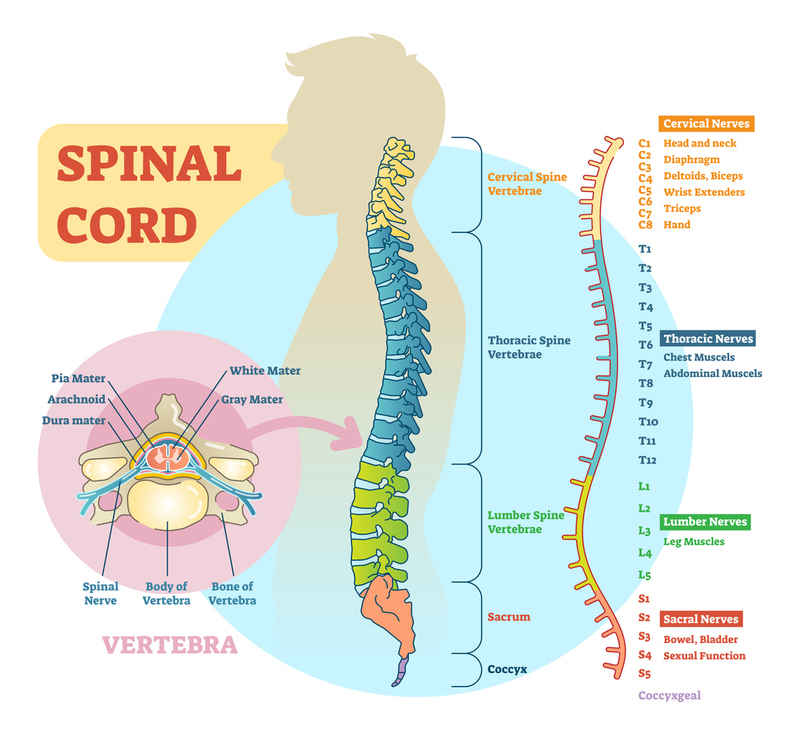

source: https://suborthonj.com/anatomy-of-the-spine/

In [9]:
merged_df.dropna(subset=['level'], inplace=True)

In [10]:
merged_df.isnull().sum()

study_id                                     0
spinal_canal_stenosis_l1_l2                  0
spinal_canal_stenosis_l2_l3                  0
spinal_canal_stenosis_l3_l4                  0
spinal_canal_stenosis_l4_l5                  0
spinal_canal_stenosis_l5_s1                  0
left_neural_foraminal_narrowing_l1_l2       30
left_neural_foraminal_narrowing_l2_l3       30
left_neural_foraminal_narrowing_l3_l4       30
left_neural_foraminal_narrowing_l4_l5       30
left_neural_foraminal_narrowing_l5_s1       30
right_neural_foraminal_narrowing_l1_l2     180
right_neural_foraminal_narrowing_l2_l3     180
right_neural_foraminal_narrowing_l3_l4     180
right_neural_foraminal_narrowing_l4_l5     180
right_neural_foraminal_narrowing_l5_s1     180
left_subarticular_stenosis_l1_l2          3508
left_subarticular_stenosis_l2_l3          1651
left_subarticular_stenosis_l3_l4            65
left_subarticular_stenosis_l4_l5            69
left_subarticular_stenosis_l5_s1           252
right_subarti

In [11]:
merged_df.iloc[1]

study_id                                                4003253
spinal_canal_stenosis_l1_l2                         Normal/Mild
spinal_canal_stenosis_l2_l3                         Normal/Mild
spinal_canal_stenosis_l3_l4                         Normal/Mild
spinal_canal_stenosis_l4_l5                         Normal/Mild
spinal_canal_stenosis_l5_s1                         Normal/Mild
left_neural_foraminal_narrowing_l1_l2               Normal/Mild
left_neural_foraminal_narrowing_l2_l3               Normal/Mild
left_neural_foraminal_narrowing_l3_l4               Normal/Mild
left_neural_foraminal_narrowing_l4_l5                  Moderate
left_neural_foraminal_narrowing_l5_s1               Normal/Mild
right_neural_foraminal_narrowing_l1_l2              Normal/Mild
right_neural_foraminal_narrowing_l2_l3              Normal/Mild
right_neural_foraminal_narrowing_l3_l4                 Moderate
right_neural_foraminal_narrowing_l4_l5                 Moderate
right_neural_foraminal_narrowing_l5_s1  

In [12]:
def combine_cond_level(row):
    condition= row.condition.lower().replace(' ', '_')
    level = row.level.lower().replace('/', '_')
    col = '_'.join((condition, level))
    return row[col]

merged_df['target_area_condition'] = merged_df.apply(combine_cond_level, axis=1)

In [13]:
def target_area_id(row):
    condition = row.condition.lower().replace(' ', '_')
    level = row.level.lower().replace('/', '_')
    study_id_str = str(row.study_id)
    col = '_'.join((study_id_str, condition, level))
    return col
merged_df['target_area'] = merged_df.apply(target_area_id, axis=1)


In [14]:
merged_df

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,right_subarticular_stenosis_l5_s1,series_id,instance_number,condition,level,x,y,series_description,target_area_condition,target_area
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,7.028078e+08,8.0,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,Sagittal T2/STIR,Normal/Mild,4003253_spinal_canal_stenosis_l1_l2
1,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,7.028078e+08,8.0,Spinal Canal Stenosis,L2/L3,320.571429,295.714286,Sagittal T2/STIR,Normal/Mild,4003253_spinal_canal_stenosis_l2_l3
2,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,7.028078e+08,8.0,Spinal Canal Stenosis,L3/L4,323.030303,371.818182,Sagittal T2/STIR,Normal/Mild,4003253_spinal_canal_stenosis_l3_l4
3,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,7.028078e+08,8.0,Spinal Canal Stenosis,L4/L5,335.292035,427.327434,Sagittal T2/STIR,Normal/Mild,4003253_spinal_canal_stenosis_l4_l5
4,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,7.028078e+08,8.0,Spinal Canal Stenosis,L5/S1,353.415929,483.964602,Sagittal T2/STIR,Normal/Mild,4003253_spinal_canal_stenosis_l5_s1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48688,4290709089,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,4.237840e+09,11.0,Left Neural Foraminal Narrowing,L1/L2,219.465940,97.831063,Sagittal T1,Normal/Mild,4290709089_left_neural_foraminal_narrowing_l1_l2
48689,4290709089,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,4.237840e+09,12.0,Left Neural Foraminal Narrowing,L2/L3,205.340599,140.207084,Sagittal T1,Normal/Mild,4290709089_left_neural_foraminal_narrowing_l2_l3
48690,4290709089,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,4.237840e+09,12.0,Left Neural Foraminal Narrowing,L3/L4,202.724796,181.013624,Sagittal T1,Normal/Mild,4290709089_left_neural_foraminal_narrowing_l3_l4
48691,4290709089,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,4.237840e+09,12.0,Left Neural Foraminal Narrowing,L4/L5,202.933333,219.733333,Sagittal T1,Normal/Mild,4290709089_left_neural_foraminal_narrowing_l4_l5


In [15]:
import os
base_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification'

train_folder = os.path.join(base_path, 'train_images')
test_folder = os.path.join(base_path, 'test_images')

In [16]:
train_folder

'/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'

In [17]:
merged_df['series_id'] = merged_df['series_id'].astype(int)
merged_df['instance_number'] = merged_df['instance_number'].astype(int)


In [18]:
def generate_image_path(row, train_folder):
    image_path = f"{train_folder}/{row['study_id']}/{row['series_id']}/{row['instance_number']}.dcm"
    return image_path

merged_df['image_path'] = merged_df.apply(generate_image_path, axis=1, train_folder=train_folder)


In [19]:
merged_df.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,series_id,instance_number,condition,level,x,y,series_description,target_area_condition,target_area,image_path
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,Sagittal T2/STIR,Normal/Mild,4003253_spinal_canal_stenosis_l1_l2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
1,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286,Sagittal T2/STIR,Normal/Mild,4003253_spinal_canal_stenosis_l2_l3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
2,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182,Sagittal T2/STIR,Normal/Mild,4003253_spinal_canal_stenosis_l3_l4,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
3,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434,Sagittal T2/STIR,Normal/Mild,4003253_spinal_canal_stenosis_l4_l5,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
4,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602,Sagittal T2/STIR,Normal/Mild,4003253_spinal_canal_stenosis_l5_s1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...


In [20]:
train_spine_df = merged_df[['study_id', 'series_id','instance_number','condition', 'level', 'x', 'y', 'series_description', 'target_area_condition', 'target_area', 'image_path',]]

In [21]:
train_spine_df.head(5)

,study_id,series_id,instance_number,condition,level,x,y,series_description,target_area_condition,target_area,image_path
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,Sagittal T2/STIR,Normal/Mild,4003253_spinal_canal_stenosis_l1_l2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286,Sagittal T2/STIR,Normal/Mild,4003253_spinal_canal_stenosis_l2_l3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182,Sagittal T2/STIR,Normal/Mild,4003253_spinal_canal_stenosis_l3_l4,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434,Sagittal T2/STIR,Normal/Mild,4003253_spinal_canal_stenosis_l4_l5,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602,Sagittal T2/STIR,Normal/Mild,4003253_spinal_canal_stenosis_l5_s1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...


In [22]:
train_spine_df['series_description'].unique()

array(['Sagittal T2/STIR', 'Sagittal T1', 'Axial T2'], dtype=object)

In [23]:
# train_spine_df['target_area_condition'].value_counts()
train_spine_df.groupby(['study_id', 'series_id'])['instance_number'].count()

study_id    series_id 
4003253     702807833      5
            1054713880    10
            2448190387    10
4646740     3201256954    10
            3486248476    10
                          ..
4287160193  1507070277     5
            1820446240    10
4290709089  3274612423     5
            3390218084    10
            4237840455    10
Name: instance_number, Length: 6291, dtype: int64

In [24]:

# # import matplotlib.pyplot as plt
# # import pandas as pd

# def plot_image(image_path:pd.Series, count_of_images: int=5, x:pd.Series|None=None, y:pd.Series|None=None):
#     for path in image_path[:count_of_images]:
#         image_data = pydicom.dcmread(path)
#         plt.imshow(image_data.pixel_array, cmap='gray')
#         if x is not None and y is not None:
#             plt.scatter(x[:count_of_images], y[:count_of_images], c='red')
#             plt.show()
            
# plot_image(train_spine_df.image_path, x=train_spine_df.x, y=train_spine_df.y)

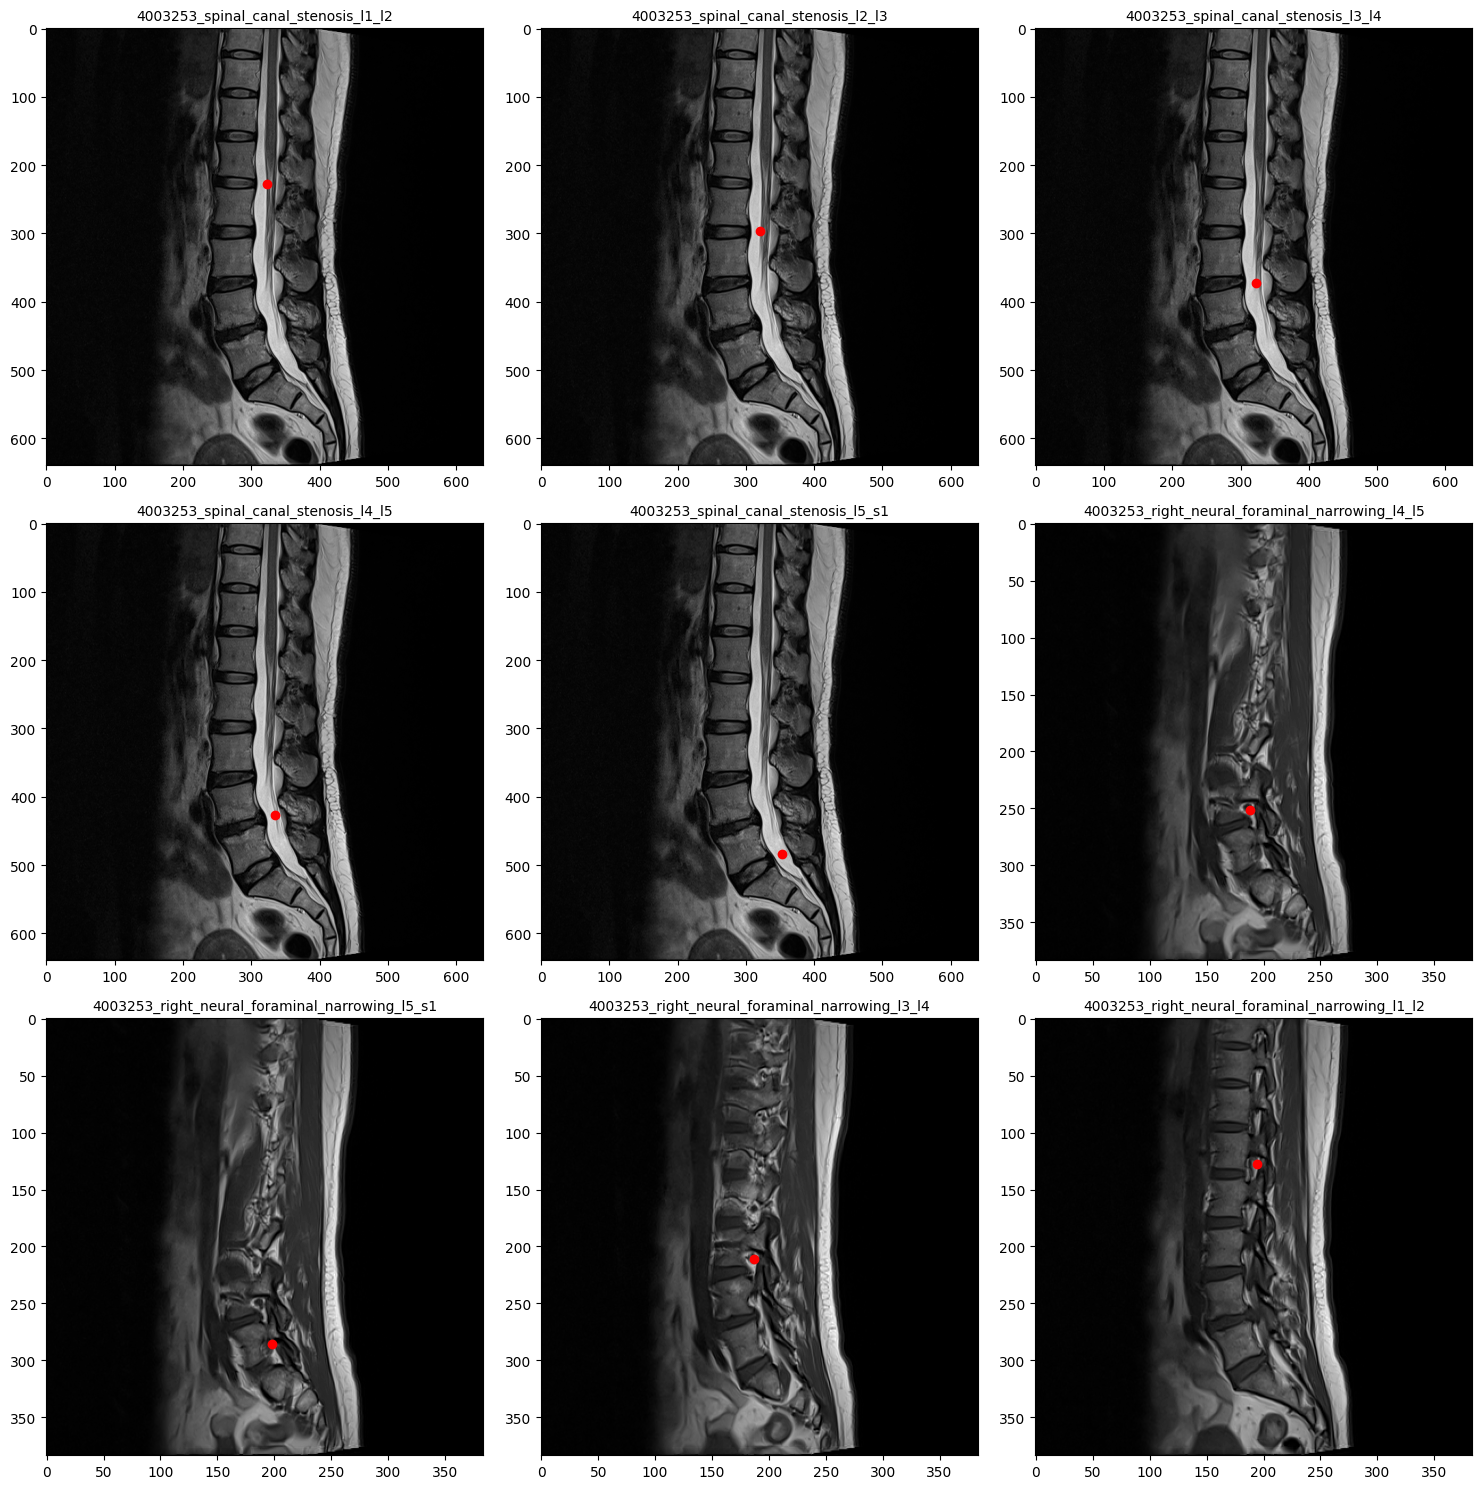

In [25]:
# import pydicom
# import matplotlib.pyplot as plt
import pandas as pd

def plot_image(image_path: pd.Series, target: pd.Series, count_of_images: int = 5, x: pd.Series|None = None, y: pd.Series|None = None, columns: int = 3):
    # Determine the number of rows needed
    rows = (count_of_images + columns - 1) // columns
    
    # Create subplots
    fig, axes = plt.subplots(rows, columns, figsize=(15, 5 * rows))
    axes = axes.flatten()  # Flatten in case of multiple rows
    
    for i, path in enumerate(image_path[:count_of_images]):
        ax = axes[i]
        image_data = pydicom.dcmread(path)
        ax.imshow(image_data.pixel_array, cmap='gray')
        # ax.axis('off')  # Hide the axes
        
        # Set the title as the target area
        ax.set_title(target.iloc[i], fontsize=10)
        
        # If x and y are provided, plot points
        if x is not None and y is not None:
            ax.scatter(x.iloc[i], y.iloc[i], c='red')
    
    # Hide any unused subplots
    for ax in axes[count_of_images:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_image(train_spine_df.image_path, target=train_spine_df.target_area, x=train_spine_df.x, y=train_spine_df.y, count_of_images=9, columns=3)


In [26]:
train_spine_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48692 entries, 0 to 48692
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   study_id               48692 non-null  int64  
 1   series_id              48692 non-null  int64  
 2   instance_number        48692 non-null  int64  
 3   condition              48692 non-null  object 
 4   level                  48692 non-null  object 
 5   x                      48692 non-null  float64
 6   y                      48692 non-null  float64
 7   series_description     48692 non-null  object 
 8   target_area_condition  48657 non-null  object 
 9   target_area            48692 non-null  object 
 10  image_path             48692 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 4.5+ MB


In [27]:
# Ensure train_spine_df is a copy if it might be a view
train_df = train_spine_df.copy()

# Apply the transformation
for col in train_df.columns:
    train_df.loc[:, col] = train_df[col].apply(lambda x: None if x == 'nan' else x)


In [28]:
train_spine_df.dropna(inplace=True)


/tmp/ipykernel_18/1055982181.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_spine_df.dropna(inplace=True)


In [29]:
train_spine_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48657 entries, 0 to 48692
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   study_id               48657 non-null  int64  
 1   series_id              48657 non-null  int64  
 2   instance_number        48657 non-null  int64  
 3   condition              48657 non-null  object 
 4   level                  48657 non-null  object 
 5   x                      48657 non-null  float64
 6   y                      48657 non-null  float64
 7   series_description     48657 non-null  object 
 8   target_area_condition  48657 non-null  object 
 9   target_area            48657 non-null  object 
 10  image_path             48657 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 4.5+ MB


In [30]:
test_desc_df

,study_id,series_id,series_description
0,44036939,2828203845,Sagittal T1
1,44036939,3481971518,Axial T2
2,44036939,3844393089,Sagittal T2/STIR


In [31]:
test_study_id = []
test_series_id = []
test_image_path = []
instance_number = []
for study in os.listdir(test_folder):
    study_path = os.path.join(test_folder, study)
    
    for series in os.listdir(study_path):
        series_path = os.path.join(study_path, series)
        
        for image in os.listdir(series_path):
            image_path = os.path.join(series_path, image)
            
            test_study_id.append(int(study))
            test_series_id.append(int(series))
            test_image_path.append(image_path)
            instance_number.append(int(image.rstrip('.dcm')))

In [32]:
test_spine_df = pd.DataFrame({'study_id': test_study_id, 'series_id': test_series_id, 'instance_number': instance_number, 'image_path': test_image_path})

In [33]:
test_spine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   study_id         97 non-null     int64 
 1   series_id        97 non-null     int64 
 2   instance_number  97 non-null     int64 
 3   image_path       97 non-null     object
dtypes: int64(3), object(1)
memory usage: 3.2+ KB


In [34]:
test_spine_df = test_spine_df.merge(test_desc_df, on=['study_id', 'series_id'], how='inner')

In [35]:
test_spine_df.head()

,study_id,series_id,instance_number,image_path,series_description
0,44036939,3844393089,12,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T2/STIR
1,44036939,3844393089,18,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T2/STIR
2,44036939,3844393089,9,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T2/STIR
3,44036939,3844393089,22,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T2/STIR
4,44036939,3844393089,25,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T2/STIR


In [36]:
conditions = {
    'Sagittal T1': {
        'left': 'left_neural_foraminal_narrowing',
        'right': 'right_neural_foraminal_narrowing'
    },
    'Sagittal T2/STIR': 'spinal_canal_stenosis',
    'Axial T2': {
        'left': 'left_subarticular_stenosis',
        'right': 'right_subarticular_stenosis'
    }
}

new_rows = []

for _, row in test_spine_df.iterrows():
#     print(row)
    series_desc = row['series_description']
    if series_desc in conditions:
        condition_value = conditions[series_desc]
        if isinstance(condition_value, dict):
            for side, condition in condition_value.items():
                new_row = row.copy()
#                 print(new_row)
                new_row['row_id'] = f'{new_row.study_id}_{condition}'
                new_rows.append(new_row)
                
        else:
            new_row = row.copy()
            new_row['row_id'] = f'{new_row.study_id}_{condition_value}'
            new_rows.append(new_row)

In [37]:
test_spine_df = pd.DataFrame(new_rows).reset_index(drop=True)
test_spine_df

,study_id,series_id,instance_number,image_path,series_description,row_id
0,44036939,3844393089,12,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T2/STIR,44036939_spinal_canal_stenosis
1,44036939,3844393089,18,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T2/STIR,44036939_spinal_canal_stenosis
2,44036939,3844393089,9,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T2/STIR,44036939_spinal_canal_stenosis
3,44036939,3844393089,22,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T2/STIR,44036939_spinal_canal_stenosis
4,44036939,3844393089,25,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T2/STIR,44036939_spinal_canal_stenosis
...,...,...,...,...,...,...
164,44036939,2828203845,20,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T1,44036939_right_neural_foraminal_narrowing
165,44036939,2828203845,3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T1,44036939_left_neural_foraminal_narrowing
166,44036939,2828203845,3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T1,44036939_right_neural_foraminal_narrowing
167,44036939,2828203845,13,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T1,44036939_left_neural_foraminal_narrowing


In [38]:
def get_condition(row_id):
    return '_'.join(row_id.split('_')[1:])

test_spine_df['condition'] = test_spine_df.row_id.apply(lambda row_id:get_condition(row_id))

In [39]:
test_spine_df.head()

,study_id,series_id,instance_number,image_path,series_description,row_id,condition
0,44036939,3844393089,12,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T2/STIR,44036939_spinal_canal_stenosis,spinal_canal_stenosis
1,44036939,3844393089,18,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T2/STIR,44036939_spinal_canal_stenosis,spinal_canal_stenosis
2,44036939,3844393089,9,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T2/STIR,44036939_spinal_canal_stenosis,spinal_canal_stenosis
3,44036939,3844393089,22,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T2/STIR,44036939_spinal_canal_stenosis,spinal_canal_stenosis
4,44036939,3844393089,25,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Sagittal T2/STIR,44036939_spinal_canal_stenosis,spinal_canal_stenosis


In [40]:
levels = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']

def update_level(row, levels):
    level = levels[row.name % len(levels)]
    return f'{row.row_id}_{level}'

test_spine_df['row_id'] = test_spine_df.apply(lambda x: update_level(x, levels), axis=1)

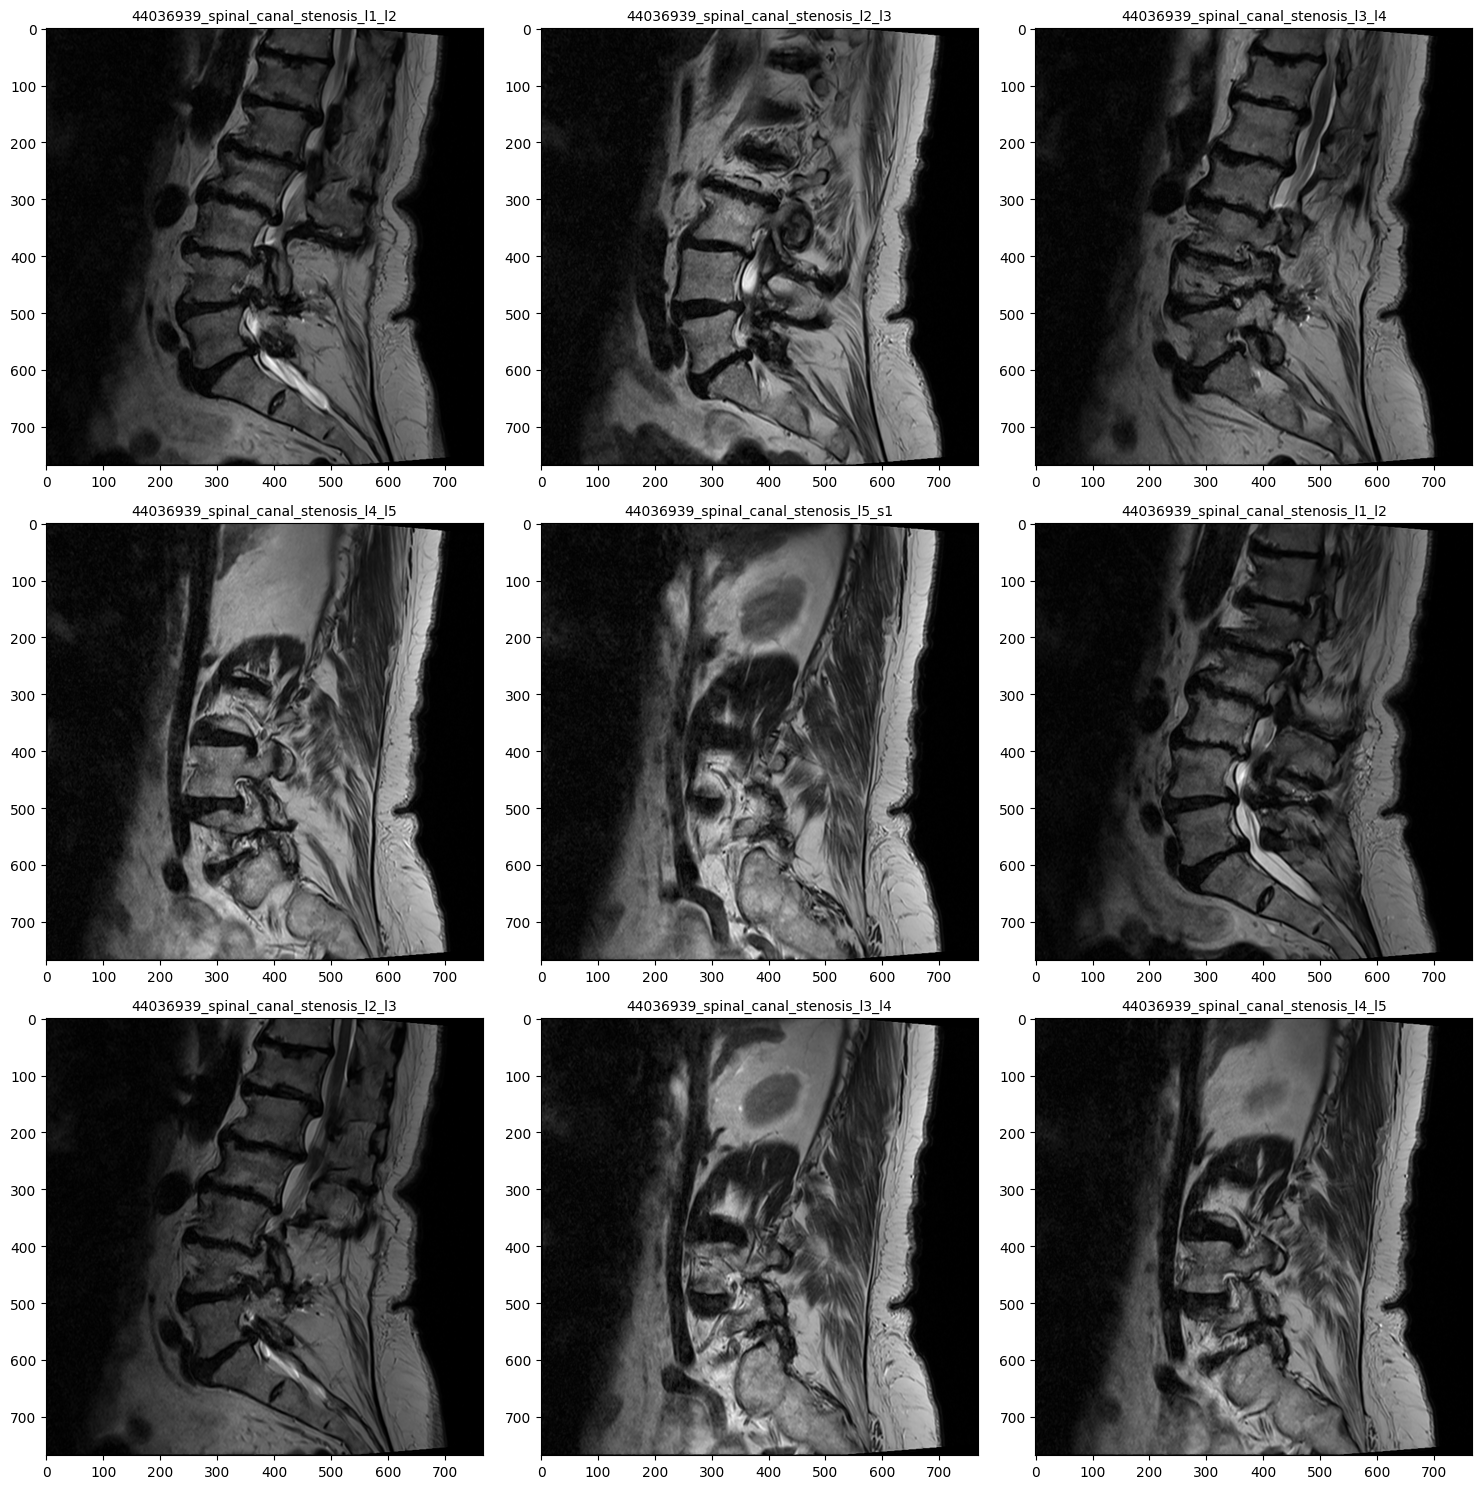

In [41]:
plot_image(test_spine_df.image_path, target=test_spine_df.row_id, count_of_images=9, columns=3)
